## Extracting Wikipedia Data on Culture and The Arts

The code focuses on retrieving page titles under two categories: "Culture" and "The Arts".

First, the `requests` and `json` libraries are imported for handling HTTP requests and parsing JSON data. The `endpoint` variable is set to the Wikipedia API URL.

Two dictionaries, `params` for "Culture" and "The Arts" categories, are defined with the necessary parameters for the API request. These parameters include the action (`query`), format (`json`), the type of list (`categorymembers`), the category title (`cmtitle`), and the limit for the number of results (`cmlimit` set to `max`).

The code then performs HTTP GET requests for each category using `requests.get()`. The responses, `culture_response` and `arts_response`, contain the raw JSON data from Wikipedia. This data is parsed into Python dictionaries, `culture_data` and `arts_data`, using the `.json()` method.

Finally, list comprehensions are used to extract the `title` of each page within the `categorymembers` of the response data, resulting in two lists: `culture_page_titles` and `arts_page_titles`, containing the page titles for the respective categories.

In [75]:
import requests
import json

endpoint = 'https://en.wikipedia.org/w/api.php'
params = {
    'action': 'query',
    'format': 'json',
    'list': 'categorymembers',
    'cmtitle': 'Category:Culture',
    'cmlimit': 'max'
}

culture_response = requests.get(endpoint, params)
culture_data = culture_response.json()

culture_page_titles = [page['title'] for page in culture_data['query']['categorymembers']]

params['cmtitle'] = 'Category:The arts'
arts_response = requests.get(endpoint, params)
arts_data = arts_response.json()

arts_page_titles = [page['title'] for page in arts_data['query']['categorymembers']]


## Processing and Storing Wikipedia Data on Culture and The Arts

### Creating Chunks of Titles
The function `chunk_list` is defined to divide a list into smaller chunks. It takes a list (`lst`) and a chunk size (`n`) as inputs. Using a `for` loop, it iterates through the list, yielding a sublist from the current index `i` to `i + n` in each iteration.

### Combining and Splitting Title Lists
Assuming `culture_page_titles` and `arts_page_titles` are pre-defined lists of page titles, they are combined into a single list `all_titles`. The total number of titles in this combined list is printed.

The combined list is then split into smaller chunks of 50 titles each, using the `chunk_list` function. These chunks are stored in the `chunks` list.

### Fetching and Combining Data for Each Chunk
An empty dictionary `combined_data` is initialized to store the combined results from the Wikipedia API. For each chunk of titles, a `titles_param` string is created by joining the titles with a `|` delimiter.

A new set of parameters `params` is defined for the Wikipedia API request, including the action (`query`), format (`json`), the concatenated titles (`titles`), and the property (`prop`) set to `info`.

The code performs an HTTP GET request for each chunk of titles. The response is parsed into JSON format, and the `pages` data from each response is added to the `combined_data` dictionary.

### Saving the Data
Finally, the combined data is saved to a file named `raw_data.json`. The `json.dump` function is used to write the `combined_data` dictionary to the file with an indentation of 4 spaces for better readability.


In [76]:
def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Assuming culture_page_titles and arts_page_titles are defined and are lists
all_titles = culture_page_titles + arts_page_titles
# print("Total number of titles:", len(all_titles))

# Splitting the titles into chunks of 50
chunks = list(chunk_list(all_titles, 50))

combined_data = {'query': {'pages': {}}}  # Initialize the structure to store combined results

for chunk in chunks:
    titles_param = '|'.join(chunk)
    params = {
        'action': 'query',
        'format': 'json',
        'titles': titles_param,
        'prop': 'info',
    }

    response = requests.get(endpoint, params=params)
    data = response.json()
    combined_data['query']['pages'].update(data['query']['pages'])

# Save the combined data to a file
file_name = 'raw_data.json'
with open(file_name, 'w') as f:
    json.dump(combined_data, f, indent=4)

## Analyzing Wikipedia Page Update Frequencies

This section focuses on analyzing the update frequencies of Wikipedia pages related to "Culture" and "The Arts", using the combined data obtained from previous steps.

### Importing Necessary Libraries
The Python libraries `pandas` for data manipulation, `matplotlib.pyplot` for plotting, and `datetime` for handling date and time are imported.

### Creating a DataFrame from the Extracted Data
The `combined_data` dictionary, which contains the Wikipedia pages' information, is processed to extract the values under `'query' -> 'pages'`. These values are converted into a list, `page_info_list`.

A Pandas DataFrame, `df`, is then created from `page_info_list`. This DataFrame represents the structured data for each Wikipedia page, including metadata such as the last time each page was updated (`touched`).

### Processing Date Information
The `touched` column in `df`, which represents the last update timestamp of each page, is converted to a Pandas `datetime` object for easier manipulation.

A new column, `days_since_last_update`, is calculated for each page. This column represents the number of days since the page was last updated. It is computed by subtracting the `touched` datetime from the current UTC datetime, with the result converted to days.

### Saving the Analyzed Data to a CSV File
The final DataFrame `df` is saved to a CSV file, `wiki_page_info.csv`. The `to_csv` method is used for this purpose, with `index=False` to exclude the DataFrame index from the file. This CSV file can then be used for further analysis or reporting purposes.

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone

page_info_list = [info for info in combined_data['query']['pages'].values()]

df = pd.DataFrame(page_info_list)

df['touched'] = pd.to_datetime(df['touched'])

df['days_since_last_update'] = (datetime.utcnow().replace(tzinfo=timezone.utc) - df['touched']).dt.days

csv_file_path = 'wiki_page_info.csv'
df.to_csv(csv_file_path, index=False)

## Visualizing Wikipedia Page Length and Update Frequency

In this secion, we create visualizations to better understand the characteristics of the Wikipedia pages related to "Culture" and "The Arts", particularly focusing on page length and update frequency.

### Importing Seaborn for Visualization
The Seaborn library, an advanced visualization tool, is imported with the alias `sns`.

### Histogram of Page Lengths
- A histogram is plotted to visualize the distribution of page lengths within the dataset.
- `plt.figure(figsize=(10, 5))` sets the size of the plot.
- `sns.histplot` is used to create the histogram, targeting the `length` column of our DataFrame `df`. We specify 30 bins for the histogram and enable Kernel Density Estimate (KDE) for a smooth curve representation of the distribution.
- The plot is titled 'Distribution of Page Lengths' and labeled with 'Page Length (bytes)' on the x-axis and 'Frequency' on the y-axis.

### Bar Chart of Days Since Last Update for Each Page
- A bar chart is created to show the days since the last update for each Wikipedia page in our dataset.
- Again, the plot size is set using `plt.figure(figsize=(10,5))`.
- The `days_since_last_update` column from `df` is used to plot the bar chart, with each bar colored in light coral.
- The chart is titled 'Days Since Last Update for Each Page'. The x-axis is labeled 'Page ID', representing the individual pages, and the y-axis shows 'Days Since Last Update', indicating the recency of the page's last edit.

Both plots are displayed using `plt.show()`, which renders them in the notebook. These visualizations provide valuable insights into the size and freshness of content in the selected Wikipedia categories.


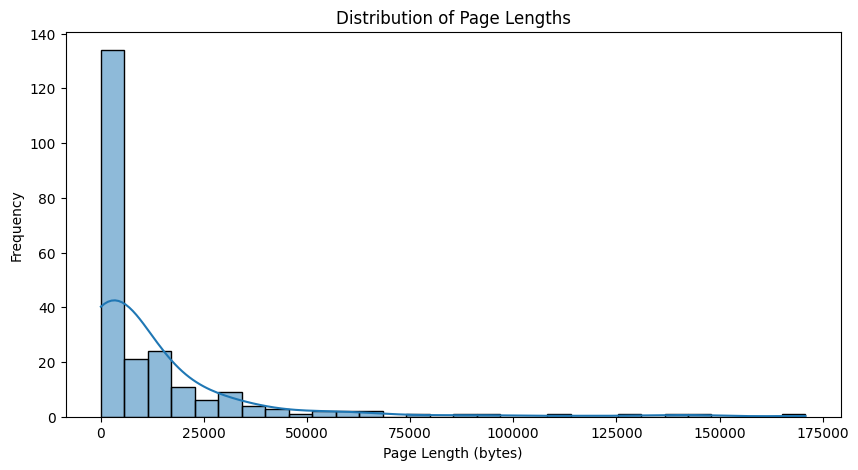

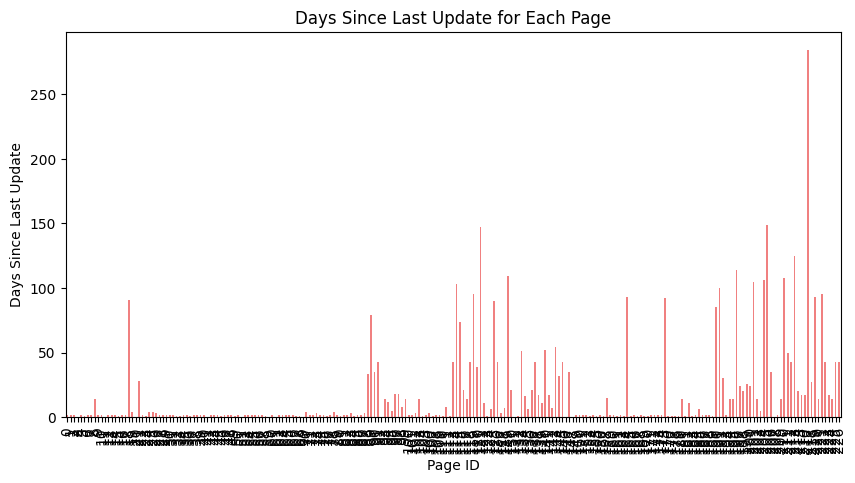

In [78]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['length'], bins=30, kde=True)
plt.title('Distribution of Page Lengths')
plt.xlabel('Page Length (bytes)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,5))
df['days_since_last_update'].plot(kind='bar', color='lightcoral')
plt.title('Days Since Last Update for Each Page')
plt.xlabel('Page ID')
plt.ylabel('Days Since Last Update')
plt.show()

In [79]:
# Generating Descriptive Statistics
# Summary statistics for the 'length' column
length_stats = df['length'].describe()
print("Descriptive Statistics for Page Lengths:\n", length_stats)

# Summary statistics for the 'days_since_last_update' column
update_stats = df['days_since_last_update'].describe()
print("\nDescriptive Statistics for Days Since Last Update:\n", update_stats)

length_mode = df['length'].mode()[0]
update_mode = df['days_since_last_update'].mode()[0]
print("\nMode for Page Lengths:", length_mode)
print("Mode for Days Since Last Update:", update_mode)

Descriptive Statistics for Page Lengths:
 count       227.000000
mean      13154.801762
std       24953.967917
min          42.000000
25%         179.500000
50%        4166.000000
75%       14882.000000
max      170827.000000
Name: length, dtype: float64

Descriptive Statistics for Days Since Last Update:
 count    227.000000
mean      18.083700
std       34.794174
min        0.000000
25%        2.000000
50%        2.000000
75%       17.000000
max      284.000000
Name: days_since_last_update, dtype: float64

Mode for Page Lengths: 69
Mode for Days Since Last Update: 2
